# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

## Scatter plots

I'll start with the data from the BRFSS again.

In [3]:
df = brfss.ReadBrfss(nrows=None)

The following function selects a random subset of a `DataFrame`.

In [4]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [5]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

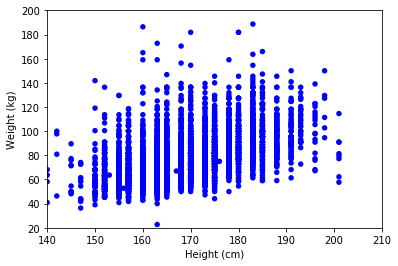

In [6]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

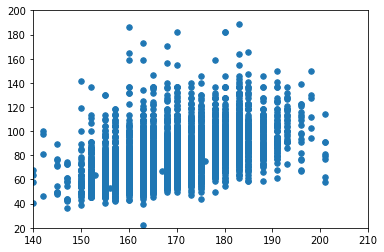

In [7]:
# Mine
fig,ax = plt.subplots()

ax.scatter(heights, weights, alpha=1, s=30)

ax.set_xlim(140,210)
ax.set_ylim(20,200)

plt.show()

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [8]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4.

In [9]:
heights = Jitter(heights, 1.4)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

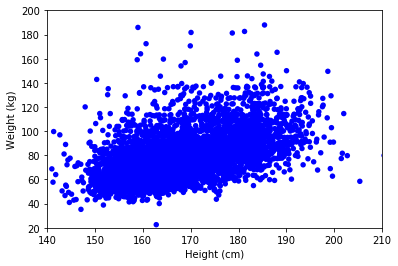

In [10]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

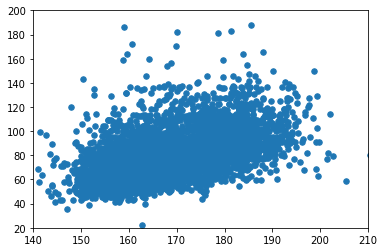

In [11]:
# Mine
fig,ax = plt.subplots()

ax.scatter(heights, weights, alpha=1, s=30)

ax.set_xlim(140,210)
ax.set_ylim(20,200)

plt.show()

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

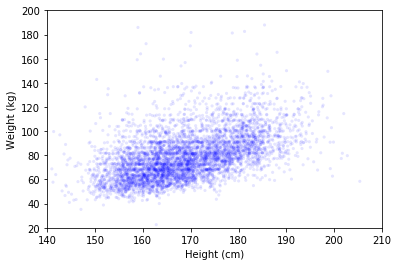

In [12]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

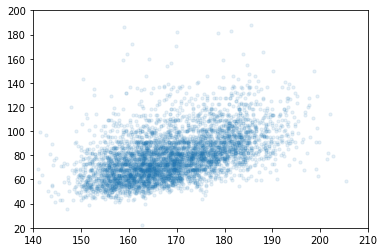

In [13]:
# Mine
fig,ax = plt.subplots()

ax.scatter(heights, weights, alpha=0.1, s=10)

ax.set_xlim(140,210)
ax.set_ylim(20,200)

plt.show()

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

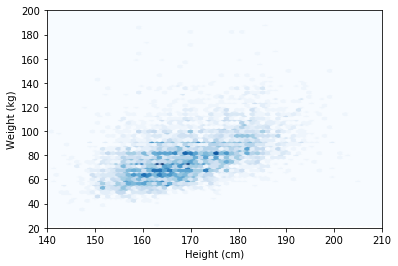

In [14]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

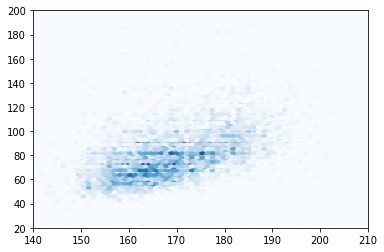

In [15]:
# Mine, uses a different colormap from the default (see below), same cmap used in the book.
# The default cmap is bright yellow on dark background. Looks cool.
fig,ax = plt.subplots()

ax.hexbin(heights, weights, cmap=matplotlib.cm.Blues)

ax.set_xlim(140,210)
ax.set_ylim(20,200)

plt.show()

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

In [16]:
# Solution goes here
df.dropna(subset=['htm3','wtkg2'], inplace=True)

heights_all = df.htm3
weights_all = df.wtkg2

heights_all = Jitter(heights_all, 2.2)
weights_all = Jitter(weights_all, 0.8)

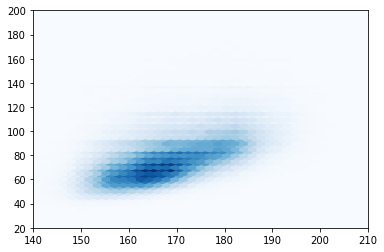

In [17]:
# Mine
fig,ax = plt.subplots()

ax.hexbin(heights_all, weights_all, cmap=matplotlib.cm.Blues)
#ax.scatter(heights_all, weights_all, alpha=0.01, s=2)

ax.set_xlim(140,210)
ax.set_ylim(20,200)

plt.show()

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [18]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [19]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

In [20]:
indices

array([5, 6, 8, ..., 9, 5, 9], dtype=int64)

Here are the number of respondents in each group:

In [21]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [22]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

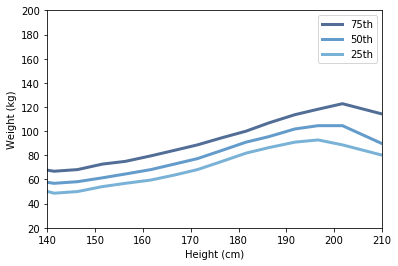

In [23]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=True)

In [24]:
# Mine, Try using pandas cut instead of digitize, but otherwise do the same.
# When I used pandas cut like this values above and below the range will be NaN for bin column.
# This seems to be an advantage of using the np.digitize method of creating bins.
# This also explains the slight difference in the tails of the plots for mine and the one in the book.
# Also try plotting whole thing without first dividing it into 25,50,75 percentiles. Should still show relationship.
# Using 'cleaned' from above
bins = np.arange(135, 215, 5)
cleaned['h_bins'] = pd.cut(cleaned.htm3, bins)

In [25]:
def DiscreteRv(a):
    """Creates a scipy.stats discrete_rv.

    Arguments:
        a {array-like} -- a single data set, will be flattened if it is not already 1-D

    Returns:
        An instance of scipy.stats discrete_rv representing the input data
    """
    val,cnt = np.unique(a, return_counts=True)
    
    return stats.rv_discrete(values=(val,cnt/sum(cnt)))

In [26]:
# Create the data for plotting: height means for x and rvs for y
h_groups = cleaned.groupby('h_bins')

h_means = np.array(h_groups.htm3.mean())
w_rvs = [DiscreteRv(group.wtkg2) for i, group in h_groups]

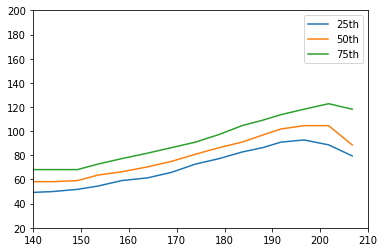

In [27]:
# Seems to be working, axis limits need adjustment
fig,ax = plt.subplots()

for p in [0.25, 0.50, 0.75]:
    w_rv = [rv.ppf(p) for rv in w_rvs]
    label = '{}th'.format(int(p*100))
    ax.plot(h_groups.htm3.mean(),w_rv, label=label)

ax.legend()
ax.set_xlim(140,210)
ax.set_ylim(20,200)

plt.show()

In [28]:
cleaned[cleaned.htm3 == 236.0]

,age,sex,wtyrago,finalwt,wtkg2,htm3,h_bins
403966,79.0,1,136.363636,23.934809,70.45,236.0,NaN


In [29]:
cleaned.h_bins.value_counts()

(160, 165]    73792
(165, 170]    70469
(155, 160]    62081
(170, 175]    53155
(175, 180]    46471
(180, 185]    34091
(150, 155]    29171
(185, 190]     8871
(190, 195]     7782
(145, 150]     5902
(195, 200]     1780
(140, 145]     1066
(200, 205]      403
(135, 140]      224
(205, 210]       72
Name: h_bins, dtype: int64

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

In [30]:
# Solution goes here
bins=np.arange(140,210,10)

cleaned['h_bins2'] = pd.cut(cleaned.htm3, bins=bins)
groups_for_cdf = cleaned.groupby('h_bins2')

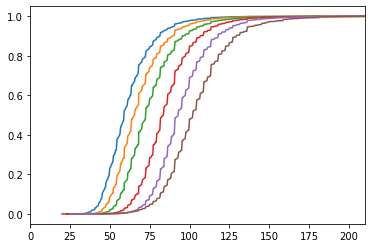

In [31]:
w_rvs_for_cdf = [DiscreteRv(group.wtkg2) for i, group in groups_for_cdf]

fig,ax = plt.subplots()

for rv in w_rvs_for_cdf:
    ax.plot(rv.xk, rv.cdf(rv.xk))

ax.set_xlim(0,210)

plt.show()

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [32]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [33]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.33290857697517

In [34]:
# Mine

np.cov(heights, weights)

array([[107.96772921, 103.33316963],
       [103.33316963, 382.12000534]])

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [35]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [36]:
Corr(heights, weights)

0.5087364789734224

In [37]:
# Mine

stats.pearsonr(heights, weights)

(0.5087364789734589, 0.0)

NumPy provides a function that computes correlations, too:

In [38]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [39]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [40]:
SpearmanCorr(heights, weights)

0.5405846262320476

In [41]:
# Mine

spear_result = stats.spearmanr(heights, weights)
spear_result

SpearmanrResult(correlation=0.5405846262320457, pvalue=0.0)

In [42]:
spear_result.correlation

0.5405846262320457

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [43]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [44]:
SpearmanCorr(heights, weights)

0.5405846262320457

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [45]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.531728260598271

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [46]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

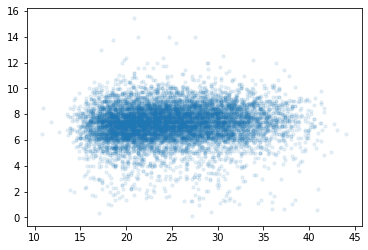

In [47]:
# Solution goes here
fig,ax = plt.subplots()

ax.scatter(live.agepreg, live.totalwgt_lb, s=10, alpha=.1)

plt.show()

In [48]:
# Solution goes here
stats.pearsonr(live.agepreg, live.totalwgt_lb)

(0.0688339703541091, 5.722947107252811e-11)

In [49]:
# Solution goes here
stats.spearmanr(live.agepreg, live.totalwgt_lb)

SpearmanrResult(correlation=0.09461004109658226, pvalue=1.9975811921504994e-19)

In [56]:
# Solution goes here
# This has essentially no correlation since scatter plot doesn't show much and r is close to zero
# Checking the book's solution it says essentially the same thing but says there could be a non-linear relationship
# To see this relationship need to use the percentile plot method.

In [58]:
# Percentile plot method
live.dropna(subset = ['agepreg', 'totalwgt_lb'], inplace = True)

In [62]:
live['agepreg_bins'] = pd.cut(live.agepreg,bins = np.arange(10,50,5))

In [64]:
live_groups = live.groupby('agepreg_bins')

In [74]:
age_means = list(live_groups.agepreg.mean())
rvs = [DiscreteRv(group.totalwgt_lb) for i, group in live_groups]

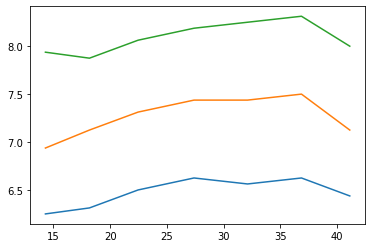

In [75]:
fig,ax = plt.subplots()

percentiles = [0.25,0.50,0.75]

for p in percentiles:
    cdf_values = [rv.ppf(p) for rv in rvs]
    ax.plot(age_means, cdf_values)

plt.show()

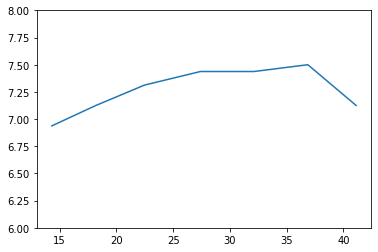

In [83]:
# Try just plotting medians(50th percentile). Gives same as above.
# All the percentiles is good extra information to have though.
weight_medians = list(live_groups.totalwgt_lb.median())

fig,ax = plt.subplots()

ax.plot(age_means, weight_medians)

ax.set_ylim(6,8)

plt.show()

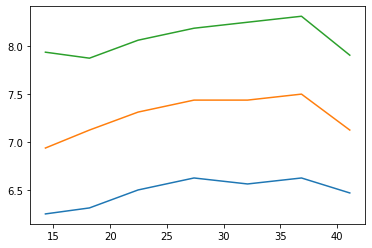

In [86]:
# Looks like I don't need to use rvs for this. Just pandas quantile.

fig,ax = plt.subplots()

percentiles = [0.25,0.50,0.75]

for p in percentiles:
    p_values = list(live_groups.totalwgt_lb.quantile(p))
    ax.plot(age_means, p_values)

plt.show()

In [51]:
# Testing conf interval function

def PearsonRandCI(x,y,alpha=0.05):
    ''' Calculate the Pearson correlation and confidence interval for two data sets.
    
    Args:
        x, y {array-like} -- Input data sets
        alpha {float} -- Significance level (default: 0.05)
   
    Returns:
        r {float} -- Pearson's correlation coefficient
        pval {float} -- The corresponding p value
        lo, hi {float} -- The lower and upper bounds of the confidence interval
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(len(x)-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [52]:
PearsonRandCI(heights, weights)

(0.5087364789734589, 0.0, 0.5064238305069129, 0.5110418086777933)

In [53]:
import math

def PearsonRandCI2(x,y,alpha=0.05):
    ''' Calculate the Pearson correlation and confidence interval for two data sets.
    
    Args:
        x, y {array-like} -- Input data sets
        alpha {float} -- Significance level (default: 0.05)
   
    Returns:
        r {float} -- Pearson's correlation coefficient
        pval {float} -- The corresponding p value
        lo, hi {float} -- The lower and upper bounds of the confidence interval
    '''

    r, p = stats.pearsonr(x,y)
    r_z = math.log((1 + r) / (1 - r)) / 2.0
    se = 1/np.sqrt(len(x)-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    e_low = math.exp(2 * lo_z)
    lo = (e_low - 1) / (e_low + 1)
    e_high = math.exp(2 * hi_z)
    hi = (e_high - 1) / (e_high + 1)
    return r, p, lo, hi

In [54]:
PearsonRandCI2(heights, weights)

(0.5087364789734589, 0.0, 0.506423830506913, 0.5110418086777933)

In [55]:
# The two methods work exactly the same way but the first has the advantage of not needing to import the math module.